In [10]:
import os
import numpy as np
import pandas as pd
import pywt
import cv2
import matplotlib.pyplot as plt
import seaborn as sn
import joblib
import json

import warnings

warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
!ls ../data/player_images/cristiano_ronaldo/cropped

cristiano_ronaldo_0.png   cristiano_ronaldo_20.png  cristiano_ronaldo_32.png
cristiano_ronaldo_10.png  cristiano_ronaldo_21.png  cristiano_ronaldo_33.png
cristiano_ronaldo_11.png  cristiano_ronaldo_22.png  cristiano_ronaldo_34.png
cristiano_ronaldo_12.png  cristiano_ronaldo_23.png  cristiano_ronaldo_35.png
cristiano_ronaldo_13.png  cristiano_ronaldo_24.png  cristiano_ronaldo_3.png
cristiano_ronaldo_15.png  cristiano_ronaldo_25.png  cristiano_ronaldo_5.png
cristiano_ronaldo_16.png  cristiano_ronaldo_26.png  cristiano_ronaldo_6.png
cristiano_ronaldo_17.png  cristiano_ronaldo_27.png  cristiano_ronaldo_7.png
cristiano_ronaldo_18.png  cristiano_ronaldo_28.png  cristiano_ronaldo_8.png
cristiano_ronaldo_19.png  cristiano_ronaldo_2.png   cristiano_ronaldo_9.png
cristiano_ronaldo_1.png   cristiano_ronaldo_31.png


In [12]:
player_file_name_dict = {
    'cristiano_ronaldo':[],
    'lionel_messi': [],
    'patrick_vieira':[],
    'ronaldinho': [],
    'thierry_henry': []
}

In [13]:
folder_path = '../data/player_images/'
for player in os.listdir(folder_path):
    for file in os.listdir(folder_path + player):
        if file == 'cropped':
            for image in os.listdir(folder_path + player + '/cropped/'):
                player_file_name_dict[player].append(folder_path + player + '/cropped/' + image)
        else: continue

In [14]:
player_file_name_dict

{'cristiano_ronaldo': ['../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_7.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_23.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_22.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_16.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_15.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_33.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_9.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_34.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_8.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_12.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_18.png',
  '../data/player_images/cristiano_ronaldo/cropped/cristiano_ronaldo_32.png',
  '../data/player_images/cristiano_ronaldo/cro

In [15]:
def w2d (img, mode = 'haar', level = 1):
    
    im_array = img
    
    im_array = cv2.cvtColor(im_array,cv2.COLOR_BGR2GRAY)
    
    im_array = np.float32(im_array)
    
    im_array /= 255
    
    coeffs = pywt.wavedec2(im_array,mode,level)
    
    coeffs_H = list(coeffs)
    coeffs_H[0] *= 0
    
    im_array_H = pywt.waverec2(coeffs_H,mode)
    im_array_H *= 255
    im_array_H = np.uint8(im_array_H)
    
    return im_array_H

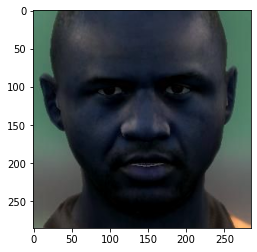

In [16]:
image = cv2.imread(player_file_name_dict['patrick_vieira'][2])
plt.imshow(image)

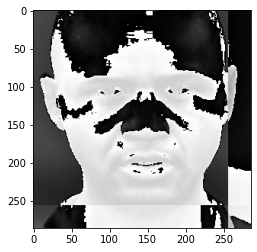

In [17]:
im_har = w2d(image,'db1',5)
plt.imshow(im_har,cmap = 'gray')

In [18]:
player_labels = {}
i = 0
for player,_ in player_file_name_dict.items():
    
    player_labels[player] = i
    i += 1 
    
player_labels

{'cristiano_ronaldo': 0,
 'lionel_messi': 1,
 'patrick_vieira': 2,
 'ronaldinho': 3,
 'thierry_henry': 4}

In [19]:
X = []
y = []

for player, image_path in player_file_name_dict.items():
    
    for image in image_path:
        
        img = cv2.imread(image)
        
        scaled_image = cv2.resize(img,(32,32))
        
        img_har = w2d(img,'db1',5)
        
        scaled_image_har = cv2.resize(img_har,(32,32))
        
        combined_img = np.vstack((scaled_image.reshape(32*32*3,1),scaled_image_har.reshape(32*32,1)))
        
        X.append(combined_img)
        
        y.append(player_labels[player])

In [20]:
len(X),len(X[0])

(159, 4096)

In [21]:
len(y)

159

In [22]:
X = np.array(X)
X = X.reshape(len(X),len(X[0])).astype(float)
y = np.array(y)
y = y.reshape(len(y),)

print(X.shape,y.shape)

(159, 4096) (159,)


In [23]:
X

array([[ 20.,  23.,  27., ..., 182., 181., 181.],
       [ 56.,  68.,  80., ..., 243., 243., 238.],
       [ 38.,  40.,  58., ..., 202., 215., 215.],
       ...,
       [ 89.,  14.,  58., ..., 237., 237., 237.],
       [  6.,  48.,  71., ..., 226., 213., 242.],
       [  1.,   1.,   1., ..., 233., 234., 234.]])

In [24]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4])

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

pipe = Pipeline([
    ('scaler',StandardScaler()),
    ('svc',SVC(kernel = 'rbf', C = 10))
])

pipe.fit(X_train,y_train)
pipe.score(X_test,y_test)

0.825

In [26]:
print(classification_report(y_test,pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90        11
           1       0.89      1.00      0.94         8
           2       1.00      0.50      0.67         4
           3       0.57      0.89      0.70         9
           4       1.00      0.75      0.86         8

    accuracy                           0.82        40
   macro avg       0.89      0.79      0.81        40
weighted avg       0.88      0.82      0.83        40



In [27]:
algos = {   
    
    'svm': {
        'model': SVC(gamma = 'auto',probability = True),
        'params': {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        } 
    },
    
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'randomforestclassifier__n_estimators': [1,5,10]
        } 
    },
    
    'logistic_regression': {
        'model': LogisticRegression(solver = 'liblinear',multi_class = 'auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [28]:
scores = []
best_estimators = {}

for algo, model_params in algos.items():
    
    pipe = make_pipeline(StandardScaler(),model_params['model'])
    cl = GridSearchCV(pipe,model_params['params'],cv=5,return_train_score = False)
    cl.fit(X_train,y_train)
    
    scores.append({
        'model': algo,
        'best_score': cl.best_score_,
        'best_params': cl.best_params_
    })
    
    best_estimators[algo] = cl.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df   


,model,best_score,best_params
0,svm,0.773188,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.580072,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.756884,{'logisticregression__C': 1}


In [29]:
best_estimators

{'svm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('svc',
                  SVC(C=1, gamma='auto', kernel='linear', probability=True))]),
 'random_forest': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier',
                  RandomForestClassifier(n_estimators=10))]),
 'logistic_regression': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('logisticregression',
                  LogisticRegression(C=1, solver='liblinear'))])}

In [30]:
best_estimators['svm'].score(X_test,y_test)

0.85

In [31]:
best_estimators['random_forest'].score(X_test,y_test)

0.625

In [32]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.825

In [33]:
best_classifier = best_estimators['svm']

In [34]:
cm = confusion_matrix(y_test,best_classifier.predict(X_test))
cm

array([[9, 0, 0, 2, 0],
       [0, 8, 0, 0, 0],
       [0, 0, 4, 0, 0],
       [0, 1, 0, 8, 0],
       [0, 0, 0, 3, 5]])

Text(69.0, 0.5, 'True')

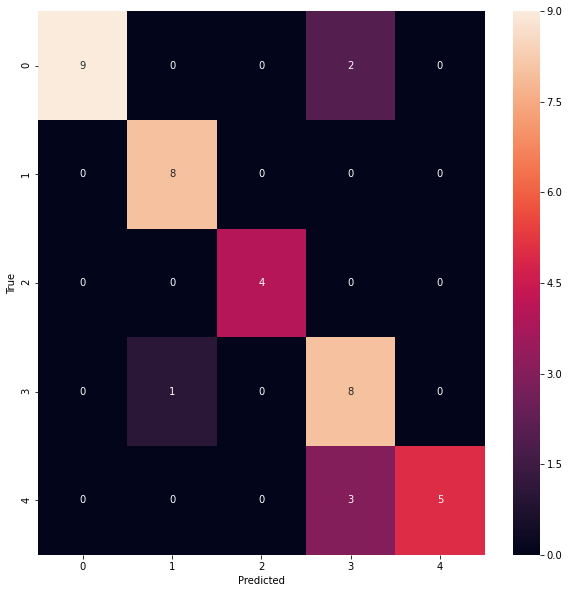

In [35]:
plt.figure(figsize = (10,10))
sn.heatmap(cm,annot = True)
plt.xlabel('Predicted')
plt.ylabel('True')

In [36]:
player_labels

{'cristiano_ronaldo': 0,
 'lionel_messi': 1,
 'patrick_vieira': 2,
 'ronaldinho': 3,
 'thierry_henry': 4}

In [37]:
joblib.dump(best_classifier,'../models/best_model.pkl')

['../models/best_model.pkl']

In [38]:
with open('../models/class_dictionary.json','w') as f:
    f.write(json.dumps(player_labels))

In [39]:
!ls ../models

best_model.pkl	class_dictionary.json
